In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.9.1


In [6]:
base_dir = "C:/Users/amoha/Desktop/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [7]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [8]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


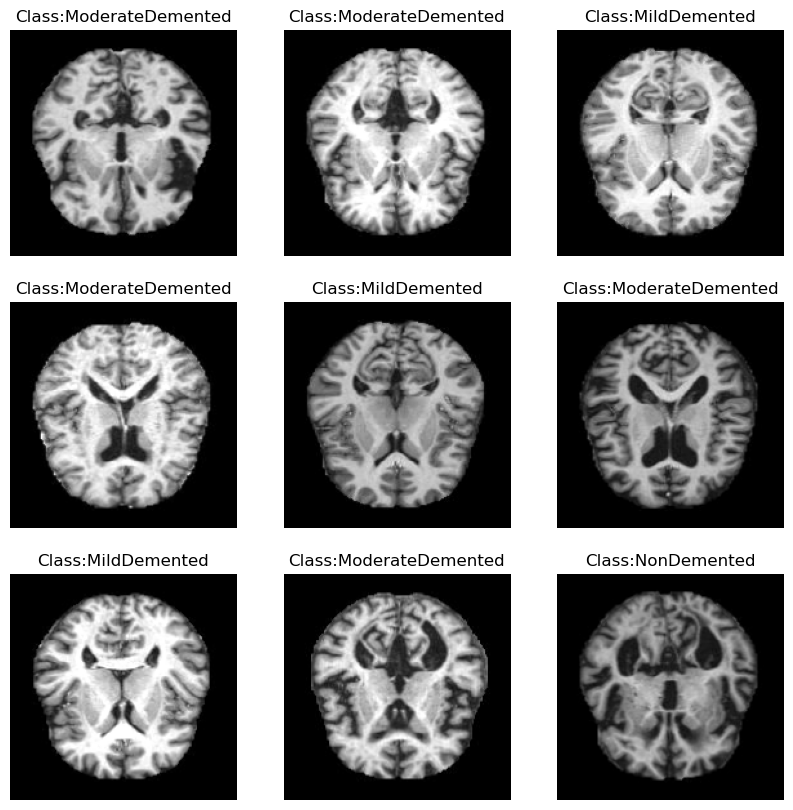

In [9]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

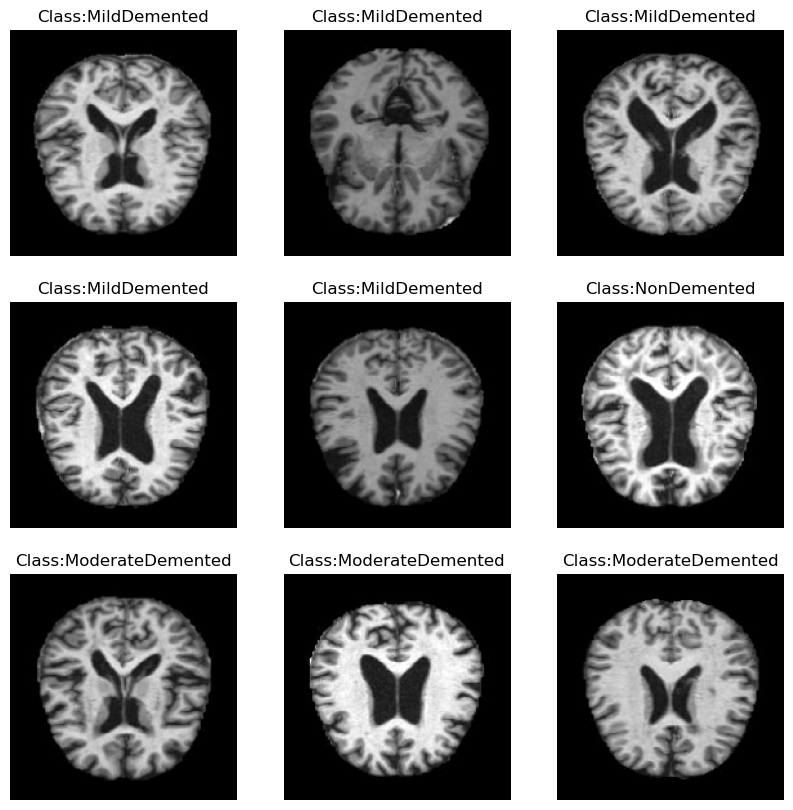

In [10]:
show_images(train_data_gen)

In [11]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [12]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [13]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [14]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [15]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [16]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [17]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.15),
        conv_block(256),
        Dropout(0.15),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [18]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [19]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

In [20]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 200

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/200
256/256 [==============================] - 152s 579ms/step - loss: 1.5370 - acc: 0.3770 - auc: 0.6475 - f1_score: 0.3714 - val_loss: 4.8475 - val_acc: 0.2402 - val_auc: 0.5074 - val_f1_score: 0.0969
Epoch 2/200
256/256 [==============================] - 151s 590ms/step - loss: 0.9764 - acc: 0.5560 - auc: 0.8293 - f1_score: 0.5488 - val_loss: 3.1553 - val_acc: 0.2402 - val_auc: 0.5505 - val_f1_score: 0.0969
Epoch 3/200
256/256 [==============================] - 144s 561ms/step - loss: 0.8118 - acc: 0.6221 - auc: 0.8782 - f1_score: 0.6156 - val_loss: 29.1396 - val_acc: 0.2402 - val_auc: 0.4935 - val_f1_score: 0.0969
Epoch 4/200
256/256 [==============================] - 139s 542ms/step - loss: 0.7548 - acc: 0.6476 - auc: 0.8941 - f1_score: 0.6397 - val_loss: 4.1666 - val_acc: 0.2402 - val_auc: 0.5046 - val_f1_score: 0.0997
Epoch 5/200
256/256 [==============================] - 137s 534ms/step - loss: 0.6932 - acc: 0.6785 - auc: 0.9097 - f1_score: 0.6733 - val_loss: 0.8798 - v

Epoch 40/200
256/256 [==============================] - 136s 532ms/step - loss: 0.0628 - acc: 0.9822 - auc: 0.9981 - f1_score: 0.9822 - val_loss: 0.3064 - val_acc: 0.9126 - val_auc: 0.9842 - val_f1_score: 0.9109
Epoch 41/200
256/256 [==============================] - 137s 534ms/step - loss: 0.0479 - acc: 0.9846 - auc: 0.9989 - f1_score: 0.9846 - val_loss: 0.2397 - val_acc: 0.9282 - val_auc: 0.9903 - val_f1_score: 0.9273
Epoch 42/200
256/256 [==============================] - 136s 533ms/step - loss: 0.0569 - acc: 0.9825 - auc: 0.9987 - f1_score: 0.9825 - val_loss: 0.2384 - val_acc: 0.9302 - val_auc: 0.9883 - val_f1_score: 0.9304
Epoch 43/200
256/256 [==============================] - 137s 534ms/step - loss: 0.0359 - acc: 0.9888 - auc: 0.9995 - f1_score: 0.9888 - val_loss: 0.4012 - val_acc: 0.9004 - val_auc: 0.9750 - val_f1_score: 0.8985
Epoch 44/200
256/256 [==============================] - 138s 539ms/step - loss: 0.0455 - acc: 0.9855 - auc: 0.9988 - f1_score: 0.9855 - val_loss: 0.4685

Epoch 79/200
256/256 [==============================] - 136s 532ms/step - loss: 0.0338 - acc: 0.9895 - auc: 0.9994 - f1_score: 0.9895 - val_loss: 0.2257 - val_acc: 0.9458 - val_auc: 0.9880 - val_f1_score: 0.9456
Epoch 80/200
256/256 [==============================] - 137s 535ms/step - loss: 0.0157 - acc: 0.9948 - auc: 0.9998 - f1_score: 0.9947 - val_loss: 0.4574 - val_acc: 0.8965 - val_auc: 0.9710 - val_f1_score: 0.8952
Epoch 81/200
256/256 [==============================] - 137s 535ms/step - loss: 0.0337 - acc: 0.9904 - auc: 0.9990 - f1_score: 0.9904 - val_loss: 0.2123 - val_acc: 0.9453 - val_auc: 0.9903 - val_f1_score: 0.9447
Epoch 82/200
256/256 [==============================] - 137s 534ms/step - loss: 0.0221 - acc: 0.9934 - auc: 0.9995 - f1_score: 0.9934 - val_loss: 0.2227 - val_acc: 0.9448 - val_auc: 0.9888 - val_f1_score: 0.9445
Epoch 83/200
256/256 [==============================] - 137s 534ms/step - loss: 0.0200 - acc: 0.9941 - auc: 0.9997 - f1_score: 0.9941 - val_loss: 0.2135

256/256 [==============================] - 151s 592ms/step - loss: 0.0168 - acc: 0.9950 - auc: 0.9997 - f1_score: 0.9950 - val_loss: 0.2887 - val_acc: 0.9399 - val_auc: 0.9829 - val_f1_score: 0.9399
Epoch 118/200
256/256 [==============================] - 157s 614ms/step - loss: 0.0215 - acc: 0.9938 - auc: 0.9994 - f1_score: 0.9938 - val_loss: 0.2382 - val_acc: 0.9404 - val_auc: 0.9869 - val_f1_score: 0.9397
Epoch 119/200
256/256 [==============================] - 151s 590ms/step - loss: 0.0194 - acc: 0.9948 - auc: 0.9993 - f1_score: 0.9947 - val_loss: 0.1888 - val_acc: 0.9536 - val_auc: 0.9901 - val_f1_score: 0.9534
Epoch 120/200
256/256 [==============================] - 155s 603ms/step - loss: 0.0052 - acc: 0.9985 - auc: 1.0000 - f1_score: 0.9985 - val_loss: 0.2249 - val_acc: 0.9551 - val_auc: 0.9845 - val_f1_score: 0.9547
Epoch 121/200
256/256 [==============================] - 155s 604ms/step - loss: 0.0167 - acc: 0.9950 - auc: 0.9996 - f1_score: 0.9950 - val_loss: 0.4167 - val_ac

256/256 [==============================] - 149s 581ms/step - loss: 0.0072 - acc: 0.9982 - auc: 0.9999 - f1_score: 0.9982 - val_loss: 0.2153 - val_acc: 0.9580 - val_auc: 0.9862 - val_f1_score: 0.9579
Epoch 156/200
256/256 [==============================] - 147s 576ms/step - loss: 0.0043 - acc: 0.9990 - auc: 0.9999 - f1_score: 0.9990 - val_loss: 0.2390 - val_acc: 0.9521 - val_auc: 0.9870 - val_f1_score: 0.9519
Epoch 157/200
256/256 [==============================] - 153s 597ms/step - loss: 0.0079 - acc: 0.9973 - auc: 0.9999 - f1_score: 0.9973 - val_loss: 0.2768 - val_acc: 0.9409 - val_auc: 0.9836 - val_f1_score: 0.9404
Epoch 158/200
256/256 [==============================] - 152s 593ms/step - loss: 0.0140 - acc: 0.9960 - auc: 0.9997 - f1_score: 0.9960 - val_loss: 0.2208 - val_acc: 0.9575 - val_auc: 0.9872 - val_f1_score: 0.9573
Epoch 159/200
256/256 [==============================] - 152s 593ms/step - loss: 0.0113 - acc: 0.9972 - auc: 0.9996 - f1_score: 0.9972 - val_loss: 0.2920 - val_ac

256/256 [==============================] - 155s 606ms/step - loss: 0.0161 - acc: 0.9956 - auc: 0.9996 - f1_score: 0.9956 - val_loss: 0.2741 - val_acc: 0.9419 - val_auc: 0.9856 - val_f1_score: 0.9412
Epoch 194/200
256/256 [==============================] - 153s 598ms/step - loss: 0.0077 - acc: 0.9976 - auc: 0.9999 - f1_score: 0.9976 - val_loss: 0.2324 - val_acc: 0.9526 - val_auc: 0.9856 - val_f1_score: 0.9523
Epoch 195/200
256/256 [==============================] - 150s 588ms/step - loss: 0.0041 - acc: 0.9991 - auc: 0.9998 - f1_score: 0.9991 - val_loss: 0.3018 - val_acc: 0.9409 - val_auc: 0.9838 - val_f1_score: 0.9411
Epoch 196/200
256/256 [==============================] - 150s 587ms/step - loss: 0.0100 - acc: 0.9971 - auc: 0.9998 - f1_score: 0.9971 - val_loss: 0.2958 - val_acc: 0.9463 - val_auc: 0.9815 - val_f1_score: 0.9455
Epoch 197/200
256/256 [==============================] - 154s 600ms/step - loss: 0.0077 - acc: 0.9976 - auc: 0.9999 - f1_score: 0.9976 - val_loss: 0.2733 - val_ac

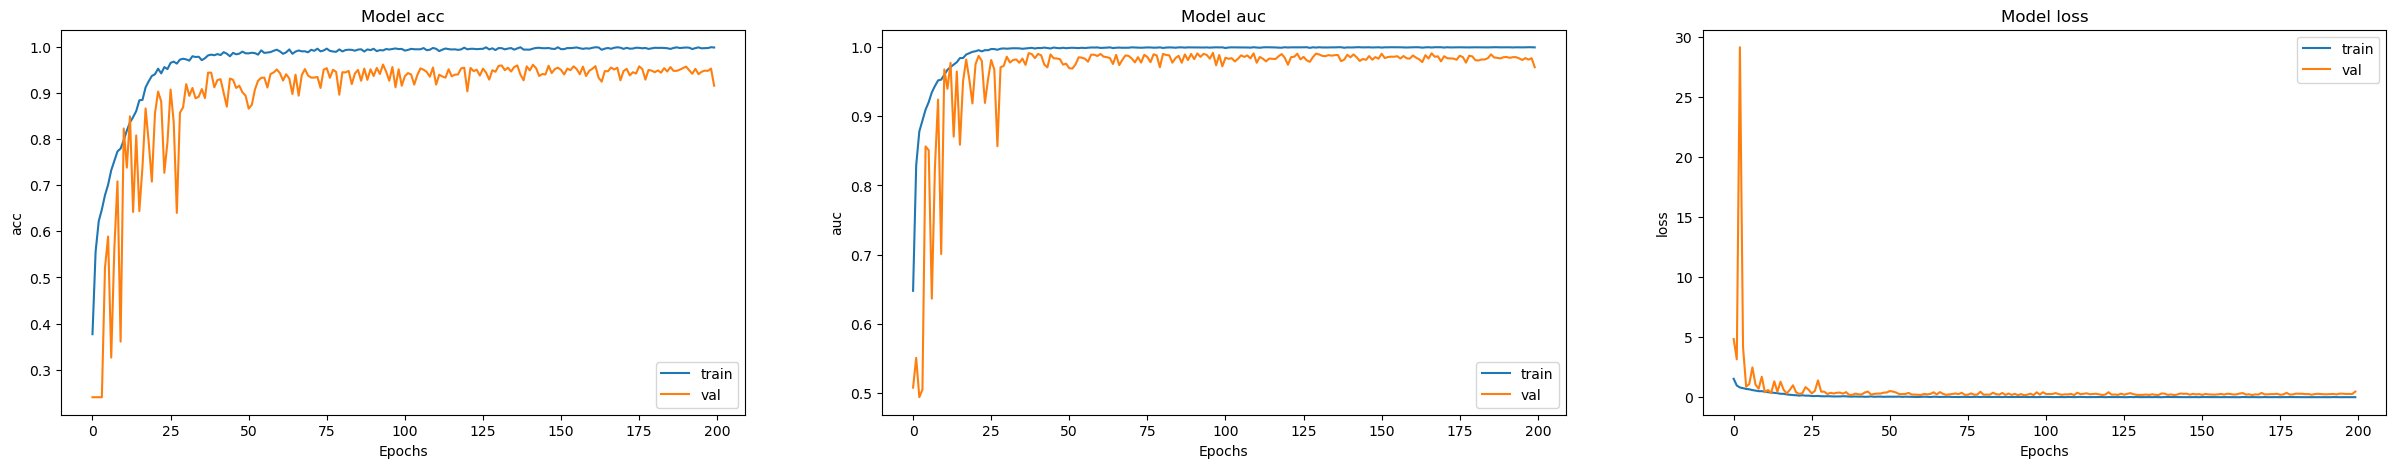

In [21]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [22]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 12s 154ms/step - loss: 0.5152 - acc: 0.9027 - auc: 0.9670 - f1_score: 0.9009
Testing Accuracy: 90.27%


In [23]:
#Predicting the test data

pred_labels = model.predict(test_data)

80/80 [==============================] - 13s 148ms/step


In [24]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.82      1.00      0.90       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.89      0.87      0.88       662
ModerateDemented       0.94      0.75      0.83       624

       micro avg       0.90      0.90      0.90      2560
       macro avg       0.91      0.90      0.90      2560
    weighted avg       0.91      0.90      0.90      2560
     samples avg       0.90      0.90      0.90      2560



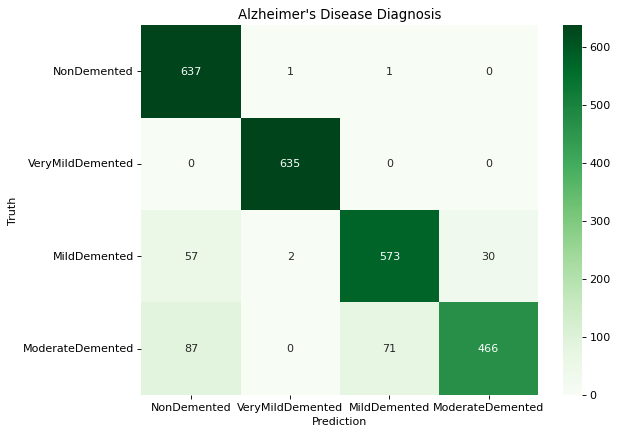

In [25]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [26]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 90.23 %
Matthew's Correlation Coefficient: 87.35 %


In [27]:
#Saving the model for future use

model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [28]:
pretrained_model = tf.keras.models.load_model(model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [29]:
!pip install visualkeras


     ---------------------------------------- 43.2/43.2 kB 4.9 kB/s eta 0:00:00


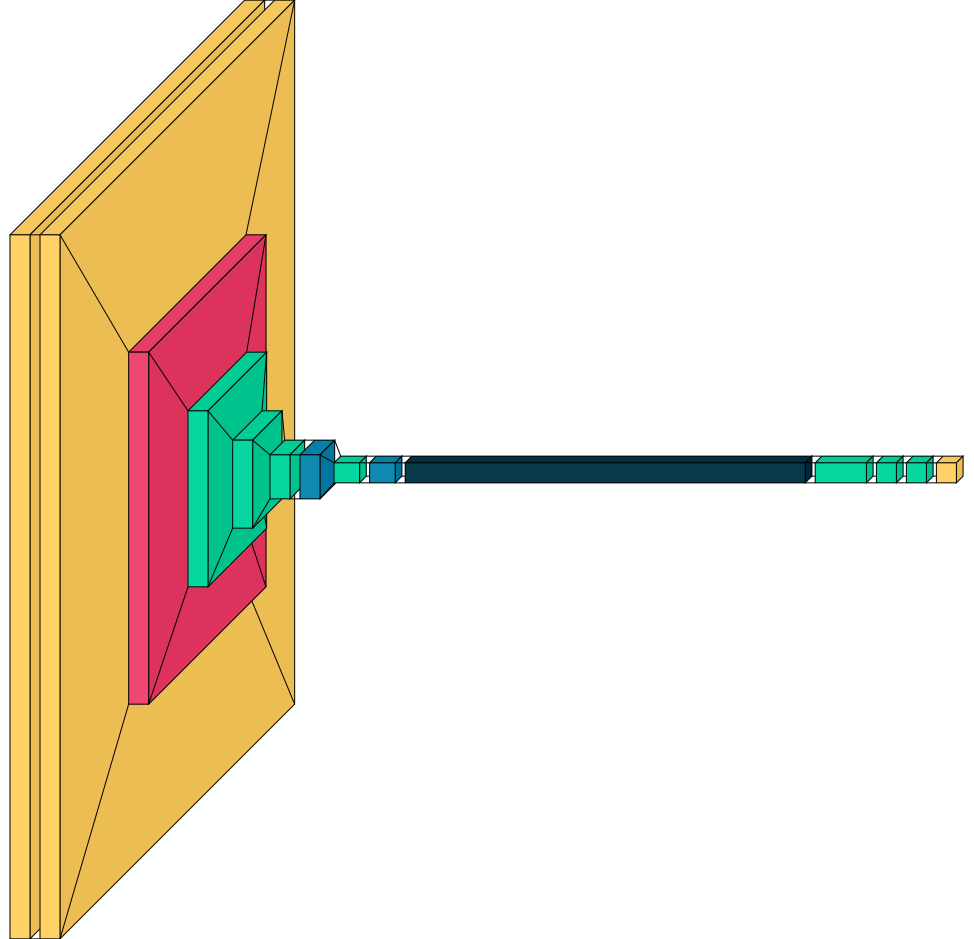

In [30]:
import visualkeras
visualkeras.layered_view(model)

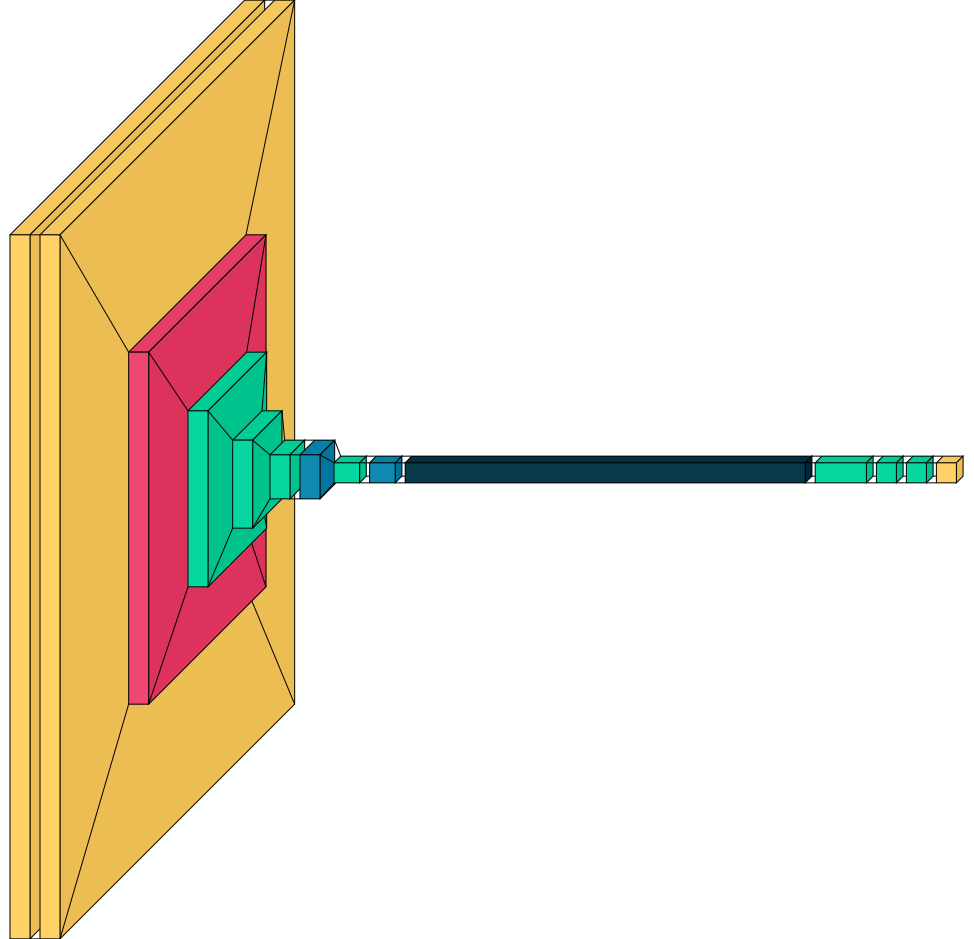

In [31]:
visualkeras.layered_view(model, to_file=work_dir + 'output.png') # write to disk
